# AutoQASM x qBraid-QIR integration POC


## Overview

This proof of concept demonstrates one potential approach to the integration between the AutoQASM and qBraid open-source projects, aiming to facilitate seamless conversion from AutoQASM to Quantum Intermediate Representation (QIR). This integration would enhance the interoperability of all involved quantum software frameworks and enable submission of quantum jobs to QIR-compatible devices using AutoQASM.

## Resources


[OpenQASM](https://openqasm.com/): Quantum assembly language that enables complex quantum programming by supporting classical logic, timing controls, and procedural programming within quantum circuits.

[QIR](https://www.qir-alliance.org/): Quantum intermediate representation based on LLVM, designed to facilitate optimization and cross-platform compatibility between different quantum processors and development tools.

[AutoQASM](https://github.com/amazon-braket/autoqasm): Experimental Python-embedded module designed to enable a Pythonic, imperative programming experience for constructing OpenQASM programs.

[qBraid-SDK](https://github.com/qBraid/qBraid): Platform-agnostic quantum runtime framework designed to streamline the full lifecycle management of quantum jobs—from defining program specifications, to job submission, and through to processing of results.

[qBraid-QIR](): qBraid-SDK extension providing support for QIR conversions, including OpenQASM 3 $\rightarrow$ QIR. 


## Goals

**Enhance Interoperability**: Ensure that AutoQASM seamlessly interacts with other quantum computing platforms to broaden its application scope.

**Submit Quantum Jobs**: Facilitate the submission of quantum jobs written in AutoQASM to the remote qBraid QIR simulator (June 2024), leveraging the strengths of both systems to provide a great end-user experience.

Run this notebook on [lab.qbraid.com](https://lab.qbraid.com) with environment access code:`592ca9a2-0881-41c4-bbf1-4b27d604afb1`

In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="networkx backend defined more than once: nx-loopback",
    category=RuntimeWarning,
)

In [2]:
import re

import autoqasm as aq
from autoqasm.instructions import cnot, h, measure

import qbraid
from qbraid.passes.qasm3.compat import add_stdgates_include, insert_gate_def
from qbraid.programs import QPROGRAM_REGISTRY, register_program_type
from qbraid.runtime.native import QbraidProvider
from qbraid.transpiler import Conversion, ConversionGraph, transpile
from qbraid.visualization.plot_counts import plot_histogram

In [3]:
qbraid.about()


qBraid-SDK: A platform-agnostic quantum runtime framework
(C) 2024 qBraid Development Team (https://github.com/qBraid/qBraid)

qbraid:	0.7.0.dev

Core Dependencies
-----------------
networkx: 3.2.1
openqasm3: 0.5.0
numpy: 1.26.4
ply: 3.11

Optional Dependencies
---------------------
qbraid_core: 0.1.6
qbraid_qir: 0.2.0
braket: 1.79.1.dev0

Python: 3.9.18
Platform: Linux (x86_64)


### OpenQASM 3 IR compatibility

The following function is where most of the collaboration will need to take place. In this function, we need to convert the OpenQASM 3 programs generated from AutoQASM into a format compatible with the qBraid-QIR qasm3 converter.


There are some OpenQASM 3 operations, such as pulse-level operations, that are not supported by QIR which we can omit for the time being. A good first step would be to ensure coverage for the entire OpenQASM 3 standard gate set. Within this gate set, there are a number of discrepancies between the AutoQASM output IR format and the supported qBraid-QIR OpenQASM 3 program input for gates like the S, T, square root of X, and phase gates, as well as in the ways measurement and qubit state initialization are handled.


Below is a basic, proof-of-concept implementation that shows what this type of bridge might look like, designed solely for internal demonstration purposes. Again, this cross-compatibility function will be central to the success of the integration.

In [4]:
def _process_qasm(qasm: str) -> str:
    """
    Convert OpenQASM 3 string to a format that
    will be accepted by the qbraid-qir converter.

    Args:
        qasm (str): The input QASM string to process.

    Returns:
        The processed QASM string.

    """
    # Regular expression to remove initialization to zeros
    pattern = r'(bit\[\d+\] +__bit_\d+__)\s+=\s+"[0]+"(;)'

    # Transform each line, removing zero initializations
    transformed_lines = [re.sub(pattern, r"\1\2", line) for line in qasm.split("\n")]

    # Rejoin the transformed lines back into a single string
    qasm = "\n".join(transformed_lines)

    # Replace specific keywords with comments in a single step to avoid multiple replacements
    qasm = re.sub(r"^(output|return_value =)", r"// \1", qasm, flags=re.MULTILINE)

    # Insert and replace various gate definitions for compatibility
    qasm = add_stdgates_include(qasm)
    qasm = insert_gate_def(qasm, "iswap")
    qasm = insert_gate_def(qasm, "sxdg")

    return qasm


def autoqasm_to_qasm3(program: aq.program.MainProgram) -> str:
    """
    Convert AutoQASM program to OpenQASM 3 string in a format that
    will be accepted by the qbraid-qir converter.

    """
    qasm = program.build().to_ir()

    return _process_qasm(qasm)

### Registering AutoQASM program type with qBraid conversion graph

The qBraid-SDK does not assume a fixed input or output/target software framework. Instead, it allows providers to dynamically register any desired run input program type as the target, depending on their specific needs.

In [5]:
register_program_type(aq.program.MainProgram)

In [6]:
QPROGRAM_REGISTRY

{'braket': braket.circuits.circuit.Circuit,
 'openqasm3': openqasm3.ast.Program,
 'pyqir': Module,
 'qasm2': str,
 'qasm3': str,
 'autoqasm': autoqasm.program.program.MainProgram}

Registered program types are then interconnected via a graph-based transpiler, where each program type is represented as a node and supported conversions as edges. The breadth, depth, and connectivity can be customized by the provider.

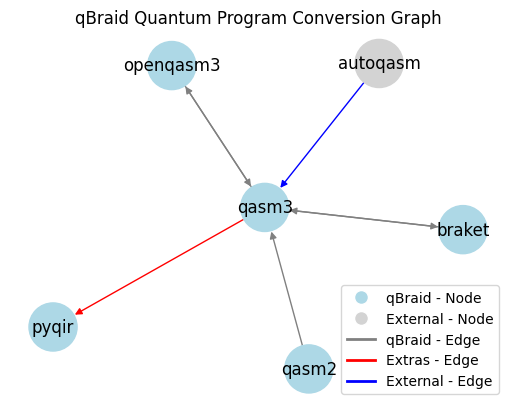

In [7]:
graph = ConversionGraph()

aq_conversion = Conversion("autoqasm", "qasm3", autoqasm_to_qasm3)

graph.add_conversion(aq_conversion)

graph.plot(legend=True)

### Submitting AutoQASM program to qBraid QIR simulator

In [8]:
provider = QbraidProvider()

device = provider.get_device("qbraid_qir_simulator")

device.update_scheme(conversion_graph=graph)

In [9]:
@aq.main
def bell_state():
    h(0)
    cnot(0, 1)
    return measure([0, 1])

In [10]:
job = device.run(bell_state, shots=100)

job.status()

<JobStatus.COMPLETED: 'job has successfully run'>

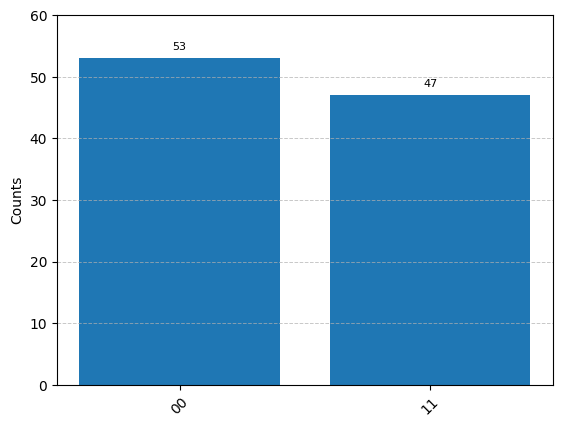

In [11]:
result = job.result()

counts = result.measurement_counts()

plot_histogram(counts)

<div class="alert alert-block alert-info">
<b>Copyright Notice:</b> 
    All rights reserved © [2024] qBraid. This notebook is part of the qBraid-SDK.
The qBraid-SDK is free software released under the GNU General Public License v3
or later. You can redistribute and/or modify it under the terms of the GPL v3.
See the LICENSE file in the project root or <https://www.gnu.org/licenses/gpl-3.0.html>. THERE IS NO WARRANTY for the qBraid-SDK, as per Section 15 of the GPL v3.
</div>